In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import os
import itertools
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [3]:
%matplotlib inline

In [5]:
ecg_data = pd.read_csv('processed_data/ecg_data.csv')

In [9]:
ecg_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [10]:
ecg_data.head()

,Segment Start,Segment End,xs0,xs1,xs2,xs3,xs4,xs5,xs6,xs7,...,xs193,xs194,xs195,xs196,xs197,xs198,xs199,Annotation Class,Annotation Class Numeric,acn
0,1284,1484,-0.058556,-0.058059,-0.057155,-0.055940,-0.054796,-0.054158,-0.054142,-0.054503,...,0.137641,0.140489,0.142698,0.144437,0.145646,0.146243,0.146136,N,1,0
1,605479,605679,0.049140,0.048014,0.045255,0.041231,0.036522,0.031692,0.027114,0.022902,...,-0.053165,-0.055104,-0.056937,-0.058567,-0.060173,-0.062033,-0.064229,L,4,3
2,21845,22045,0.059978,0.058579,0.056865,0.055295,0.053764,0.051974,0.049704,0.046862,...,-0.062430,-0.063122,-0.064830,-0.067566,-0.070728,-0.073325,-0.074336,N,1,0
3,324166,324366,-0.075383,-0.076869,-0.079413,-0.083536,-0.088039,-0.090900,-0.090414,-0.086158,...,-0.040858,-0.040343,-0.041029,-0.043588,-0.048406,-0.055377,-0.063800,N,1,0
4,127439,127639,-0.017049,-0.019908,-0.022371,-0.023693,-0.023386,-0.021627,-0.018949,-0.015967,...,0.009679,0.003653,-0.000938,-0.003769,-0.004935,-0.004898,-0.004357,N,1,0


In [11]:
ecg_data["Annotation Class"].unique()

array(['N', 'L', 'V', 'R', '/'], dtype=object)

In [12]:
id_to_label = {val: idx for idx, val in enumerate(list(ecg_data["Annotation Class"].unique()))}

In [13]:
x_columns = [f"xs{i}" for i in range(0, 200)]

In [34]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    attn_state_path = 'dl_ouptut/attn.pth'
    lstm_state_path = 'dl_ouptut/lstm.pth'
    cnn_state_path = 'dl_ouptut/cnn.pth'
    
    attn_logs = 'dl_ouptut/attn.csv'
    lstm_logs = 'dl_ouptut/lstm.csv'
    cnn_logs = 'dl_ouptut/cnn.csv'
    
    ecg_csv_path = 'ecg_data.csv'
    train_csv_path = 'processed_data/ecg_processed_train.csv'
    test_csv_path = 'processed_data/ecg_processed_test.csv'
    

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = Config()
seed_everything(config.seed)

In [35]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.X = torch.tensor(self.df.iloc[:,2:-3].values, dtype=torch.float32)
        self.y = torch.tensor(self.df.iloc[:,-1].values, dtype=torch.long) 

    def __getitem__(self, idx):
        signal = torch.reshape(self.X[idx],(1,200))
        target = self.y[idx]
        return signal, target

    def __len__(self):
        return len(self.df)

In [36]:
def get_dataloader(data_csv_path: str, phase: str, batch_size: int = 96) -> DataLoader:
    '''
    Dataset and DataLoader.
    Parameters:
        data_csv_path: processed_data path.
        phase: training, testing or validation phase.
        target: Annotation Class Numeric
        signal_cols: columns belonging to signal
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    df = pd.read_csv(data_csv_path)
    
    train_df, val_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['acn'])

    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

    if phase == 'train':
        df = train_df
    elif phase == 'val':
        df = val_df

    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
    
    return dataloader

In [37]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x, y)
        self.metrics['f1'] += f1_score(x, y, average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x, y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion


class Trainer:
    def __init__(self, train_csv_path, net, lr, batch_size, num_epochs, model_nm):
        self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.model_nm = model_nm
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(train_csv_path, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == 'train' else self.net.eval()
        meter = Meter()
        meter.init_metrics()
        

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(config.device)
            target = target.to(config.device)

            output = self.net(data)
            loss = self.criterion(output, target)
            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())
            
        metrics = meter.get_metrics()
        metrics = {k: v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()
        print("completed metrics calc")
        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
              )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train')
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
            if epoch == (self.num_epochs - 1):
                torch.save(self.net.state_dict(), f"{self.model_nm}.pth")
            # clear_output()


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""

    def __init__(
            self,
            input_size,
            hidden_size,
            kernel_size,
            norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1 + conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

class CNN(nn.Module):
    def __init__(
            self,
            input_size=1,
            hid_size=256,
            kernel_size=5,
            num_classes=5,
    ):
        super().__init__()

        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size // 2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size // 2,
            hidden_size=hid_size // 4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size // 4, out_features=num_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x

class RNN(nn.Module):
    """RNN module(cell type lstm or gru)"""

    def __init__(
            self,
            input_size,
            hid_size,
            num_rnn_layers=1,
            dropout_p=0.2,
            bidirectional=False,
            rnn_type='lstm',
    ):
        super().__init__()

        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

class RNNModel(nn.Module):
    def __init__(
            self,
            input_size,
            hid_size,
            rnn_type,
            bidirectional,
            n_classes=5,
            kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=50  ,  # hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1  )  # .squeeze(1)
        return x


class RNNAttentionModel(nn.Module):
    def __init__(
            self,
            input_size,
            hid_size,
            rnn_type,
            bidirectional,
            n_classes=5,
            kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=50,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [39]:
m1 = CNN(num_classes=5, hid_size=128)
m2 = RNNAttentionModel(1, 64, 'lstm', False)
m3 = RNNModel(1, 64, 'lstm', True)

In [40]:
model_dict = {'cnn':m1, 'attn':m2, 'lstm': m3}

In [41]:
def n_model_logs_aggregator(model, model_nm):
    
    ##training
    trainer = Trainer(train_csv_path=config.train_csv_path,net=model, lr=1e-3, batch_size=96, num_epochs=8, model_nm=model_nm)#100)
    trainer.run()
    
    ##logging
    train_logs = trainer.train_df_logs
    train_logs.columns = ["train_"+ colname for colname in train_logs.columns]
    val_logs = trainer.val_df_logs
    val_logs.columns = ["val_"+ colname for colname in val_logs.columns]

    logs = pd.concat([train_logs,val_logs], axis=1)
    logs.reset_index(drop=True, inplace=True)
    logs = logs.loc[:, [
        'train_loss', 'val_loss', 
        'train_accuracy', 'val_accuracy', 
        'train_f1', 'val_f1',
        'train_precision', 'val_precision',
        'train_recall', 'val_recall']
                                     ]
    logs.head()
    logs.to_csv(f"{model_nm}.csv", index=False)
    
    model = model.to(config.device)
    model.load_state_dict(torch.load(f"dl_output/{model_nm}.pth",map_location=config.device));
    model.eval();
    logs = pd.read_csv(f"{model_nm}.csv",)
    
    colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
    palettes = [sns.color_palette(colors, 2),
                sns.color_palette(colors, 4), 
                sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
    ax[0].set_title("Loss Function during Model Training", fontsize=14)
    ax[0].set_xlabel("Epoch", fontsize=14)

    sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
    ax[1].set_title("Metrics during Model Training", fontsize=15)
    ax[1].set_xlabel("Epoch", fontsize=14)

    plt.suptitle(f"{model_nm}", fontsize=18)

    plt.tight_layout()
    fig.savefig(f"{model_nm}.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
    fig.savefig(f"{model_nm}.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [42]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    

train mode | time: 14:01:34
completed metrics calc
loss: 1.0062380826916177, accuracy: 0.9524602854065699, f1: 0.8932440328016207, precision: 0.9050267307076898, recall: 0.9275794573370045


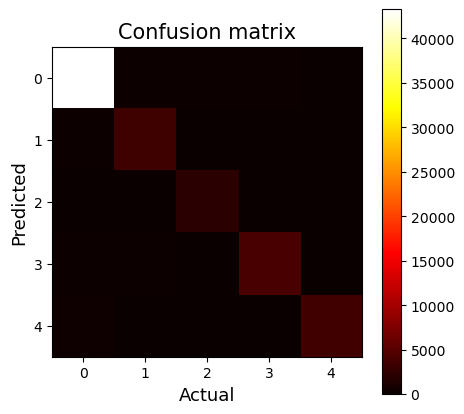

val mode | time: 14:05:09
completed metrics calc
loss: 0.9233364106960666, accuracy: 0.9956195834018985, f1: 0.9855568916640949, precision: 0.9874415688997976, recall: 0.9888162663734654


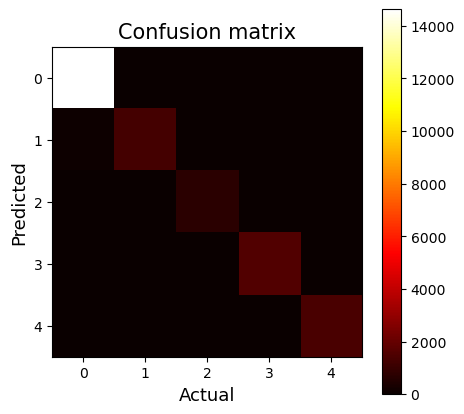


New checkpoint

train mode | time: 14:05:42
completed metrics calc
loss: 0.9194958018370707, accuracy: 0.9920234248788367, f1: 0.9827242198207577, precision: 0.9818434943785582, recall: 0.9871973837301679


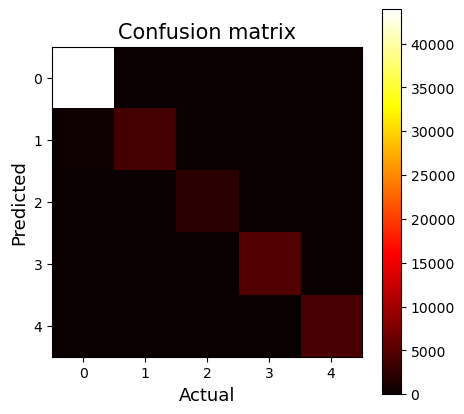

val mode | time: 14:11:52
completed metrics calc
loss: 0.9199008782511776, accuracy: 0.9963275122044878, f1: 0.9870696377263273, precision: 0.9858537640187576, recall: 0.9918175946134454


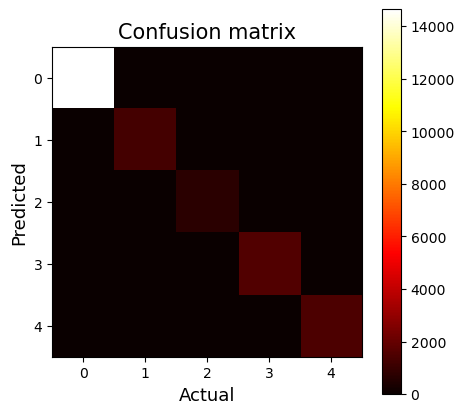

train mode | time: 14:12:24


KeyboardInterrupt: 

In [43]:

for model_nm, model in model_dict.items():
    n_model_logs_aggregator(model, model_nm)
    count_parameters(model)

In [21]:
## Testing

In [44]:
test_dataloader = get_dataloader(data_csv_path=config.test_csv_path, phase='test', batch_size =96)

In [45]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():

            data = data.to(config.device)
            cls_target = cls_target.cpu()
            print(f"pred infer begins at: {time.strftime('%H:%M:%S')}")
            cls_prediction = model(data)
            print(f"pred infer ends at: {time.strftime('%H:%M:%S')}")
            
            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)
    
            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls

In [46]:
models = [m1, m3, m2]


In [47]:
y_pred, y_true = make_test_stage(test_dataloader, models[0])
y_pred.shape, y_true.shape

pred infer begins at: 14:19:25
pred infer ends at: 14:19:26
pred infer begins at: 14:19:26
pred infer ends at: 14:19:26
pred infer begins at: 14:19:26
pred infer ends at: 14:19:26
pred infer begins at: 14:19:26
pred infer ends at: 14:19:27
pred infer begins at: 14:19:27
pred infer ends at: 14:19:27
pred infer begins at: 14:19:27
pred infer ends at: 14:19:27
pred infer begins at: 14:19:27
pred infer ends at: 14:19:27
pred infer begins at: 14:19:27
pred infer ends at: 14:19:27
pred infer begins at: 14:19:27
pred infer ends at: 14:19:27
pred infer begins at: 14:19:27
pred infer ends at: 14:19:27
pred infer begins at: 14:19:27
pred infer ends at: 14:19:28
pred infer begins at: 14:19:28
pred infer ends at: 14:19:28
pred infer begins at: 14:19:28
pred infer ends at: 14:19:28
pred infer begins at: 14:19:28
pred infer ends at: 14:19:28
pred infer begins at: 14:19:28
pred infer ends at: 14:19:28
pred infer begins at: 14:19:28
pred infer ends at: 14:19:28
pred infer begins at: 14:19:28
pred infe

((19835,), (19835,))

In [26]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

<Figure size 1400x600 with 0 Axes>

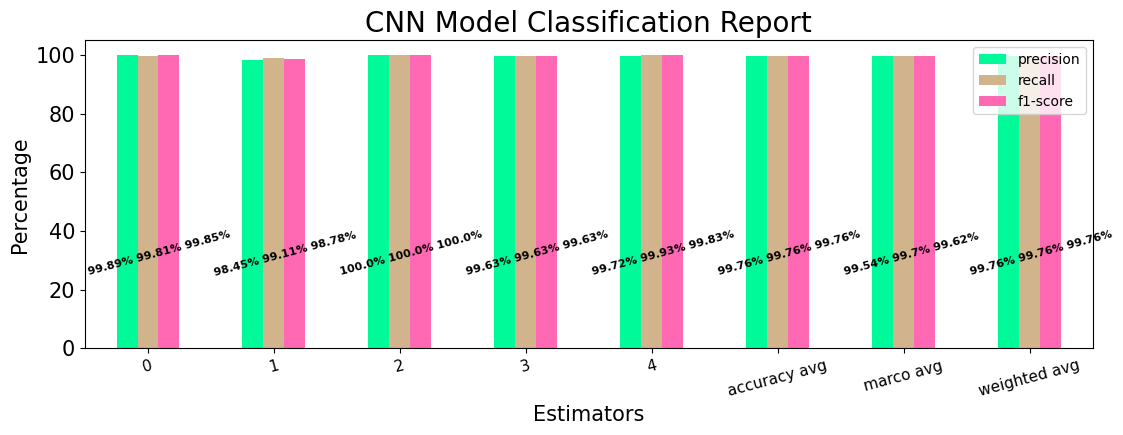

In [27]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)

fig = plt.figure(figsize=(14,6))

ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("cnn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [28]:
##cnn + lstm
y_pred, y_true = make_test_stage(test_dataloader, models[1])
y_pred.shape, y_true.shape

pred infer begins at: 16:17:10
pred infer ends at: 16:17:10
pred infer begins at: 16:17:10
pred infer ends at: 16:17:10
pred infer begins at: 16:17:10
pred infer ends at: 16:17:10
pred infer begins at: 16:17:10
pred infer ends at: 16:17:10
pred infer begins at: 16:17:10
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infe

((19835,), (19835,))

In [29]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

<Figure size 1400x600 with 0 Axes>

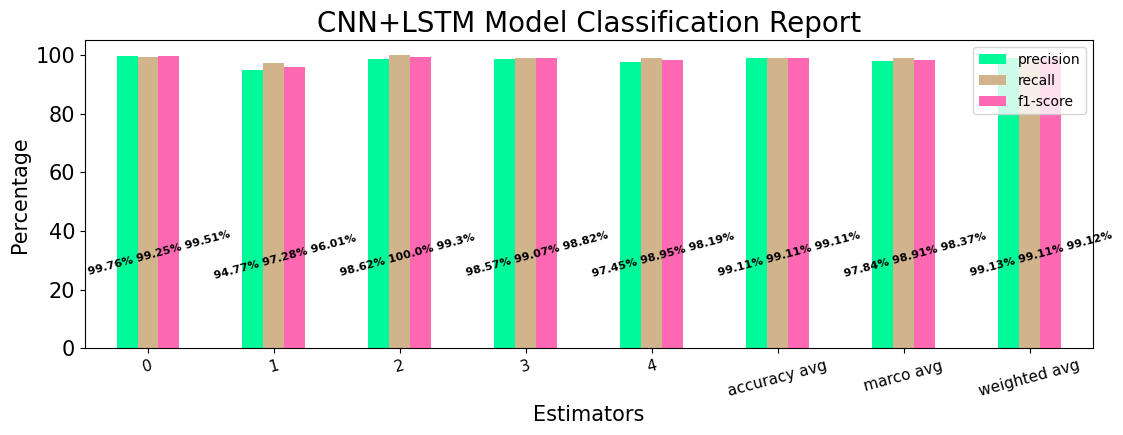

In [30]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
fig = plt.figure(figsize=(14,6))

ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("lstm_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("lstm_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [31]:
## cnn + lstm +attn
y_pred, y_true = make_test_stage(test_dataloader, models[2])
y_pred.shape, y_true.shape

pred infer begins at: 16:17:21
pred infer ends at: 16:17:21
pred infer begins at: 16:17:21
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infe

((19835,), (19835,))

In [32]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

<Figure size 1400x600 with 0 Axes>

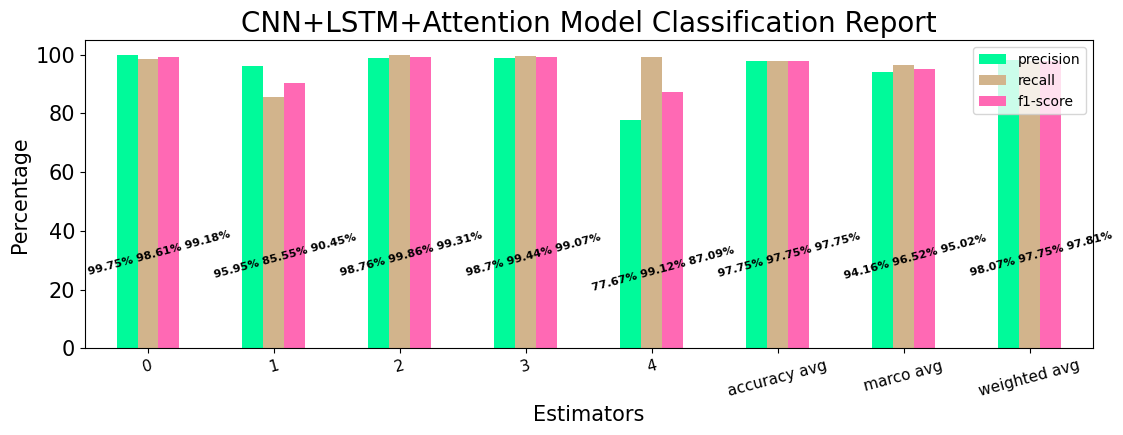

In [33]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)

fig = plt.figure(figsize=(14,6))
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM+Attention Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("attn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("attn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [34]:
## Ensemble
y_pred = np.zeros((y_pred.shape[0], 5), dtype=np.float32)
for i, model in enumerate(models, 1):
    y_pred_, y_true = make_test_stage(test_dataloader, model, True)
    y_pred += y_pred_
y_pred /= i
y_pred = np.argmax(y_pred, axis=1)

pred infer begins at: 16:17:30
pred infer ends at: 16:17:30
pred infer begins at: 16:17:30
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:32
pred infer begins at: 16:17:32
pred infe

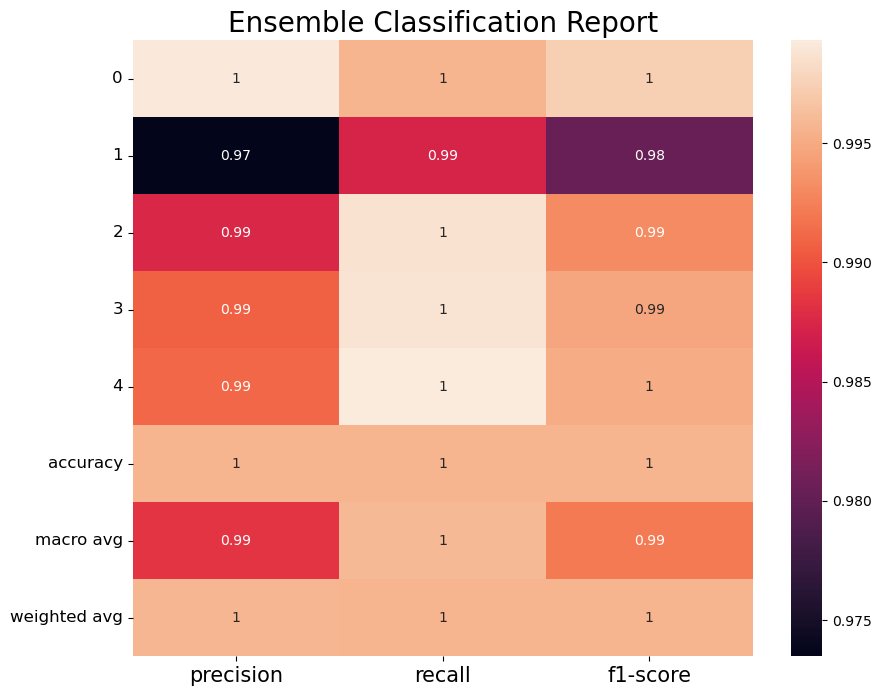

In [35]:
clf_report = classification_report(y_pred, 
                                   y_true,
                                   labels=[0,1,2,3,4],
                                   target_names=list(id_to_label.values()),#['N', 'S', 'V', 'F', 'Q'],
                                   output_dict=True)


plt.figure(figsize=(10, 8))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12, rotation=0)
plt.title("Ensemble Classification Report", fontsize=20)
plt.savefig(f"ensemble result.svg",format="svg",bbox_inches='tight', pad_inches=0.2)
plt.savefig(f"ensemble result.png", format="png",bbox_inches='tight', pad_inches=0.2)

In [36]:
clf_report

{0: {'precision': 0.9991149237472767,
  'recall': 0.9955902306648575,
  'f1-score': 0.9973494630963707,
  'support': 14740},
 1: {'precision': 0.9734904270986745,
  'recall': 0.9873039581777446,
  'f1-score': 0.9803485354097146,
  'support': 1339},
 2: {'precision': 0.9875690607734806,
  'recall': 0.9986033519553073,
  'f1-score': 0.9930555555555556,
  'support': 716},
 3: {'precision': 0.9907063197026023,
  'recall': 0.9987507807620237,
  'f1-score': 0.9947122861586314,
  'support': 1601},
 4: {'precision': 0.9910406616126809,
  'recall': 0.9993050729673384,
  'f1-score': 0.9951557093425605,
  'support': 1439},
 'accuracy': 0.9956642298966474,
 'macro avg': {'precision': 0.988384278586943,
  'recall': 0.9959106789054543,
  'f1-score': 0.9921243099125666,
  'support': 19835},
 'weighted avg': {'precision': 0.9957038283508096,
  'recall': 0.9956642298966474,
  'f1-score': 0.9956747662523722,
  'support': 19835}}